In [91]:
import importlib.util
import os
import json
from dotenv import load_dotenv
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from simpleRegArchitecture import SimpleNet

load_dotenv() 

True

In [92]:


config_file_path = os.getenv('CONFIG_FILE_PATH')
print(config_file_path)
with open(config_file_path, "r") as f:
    config = json.load(f)

#Load in the networks
output_dir = config.get("output_dir")
loaded_state_dict = torch.load(f'{output_dir}/trainedNetworks.pt')

#create new instantiations to contain the saved networks
num_networks = config.get("num_networks")
networks = []
for n in range(num_networks):
    networks.append(SimpleNet())

for i, network in enumerate(networks):
    state_dict_key = f'network_{i}'
    network.load_state_dict(loaded_state_dict[state_dict_key])




/Users/simoncole/seniorDesign/Large-Scale-Design-and-Analysis-of-Neural-Networks/config.json


In [93]:
#input 
#weights: a 1D numpy array of all the weights to be analyzed
#num_bins: the number of equal size bins to be generated
#returns
#
def generate_bins(weights, num_bins):
    min_val = min(weights)
    max_val = max(weights)

    bin_boundaries = np.linspace(min_val, max_val, num_bins + 1)
    bins = list(zip(bin_boundaries[:-1], bin_boundaries[1:]))
    return bins

def populate_bins(weights, bins):
    min_val = min(weights)
    max_val = max(weights)
    num_bins = len(bins)
    resolution = (max_val - min_val) / num_bins

    bin_counts = np.zeros(num_bins, dtype=int)

    for weight in weights:
        bin_index = int((weight - min_val) / resolution)

        #edge case for max val
        if bin_index == num_bins:
            bin_index = num_bins - 1
        
        bin_counts[bin_index] += 1
    
    return bin_counts

In [94]:

all_weights = []
for network in networks:
    weights_np = network.fc1.weight.data.numpy().flatten()
    all_weights = np.concatenate((all_weights, weights_np))

bins = generate_bins(all_weights, 10)
bin_counts = populate_bins(all_weights, bins)

print(bins)
print(bin_counts)

[(-0.8101912140846252, -0.6342655003070832), (-0.6342655003070832, -0.458339786529541), (-0.458339786529541, -0.2824140727519988), (-0.2824140727519988, -0.10648835897445674), (-0.10648835897445674, 0.06943735480308533), (0.06943735480308533, 0.24536306858062762), (0.24536306858062762, 0.4212887823581697), (0.4212887823581697, 0.5972144961357118), (0.5972144961357118, 0.7731402099132538), (0.7731402099132538, 0.9490659236907959)]
[ 8 11 14 10 15 11 10 11  7  3]


[-0.7222283571958542, -0.546302643418312, -0.3703769296407699, -0.19445121586322778, -0.018525502085685708, 0.15740021169185647, 0.33332592546939865, 0.5092516392469407, 0.6851773530244828, 0.8611030668020249]


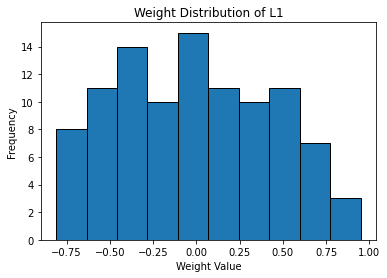

In [95]:
#Visualize

# Calculate bin centers for plotting
bin_centers = []
resolution = bins[0][1] - bins[0][0]
for b in bins:
    bin_centers.append(((b[1] - b[0]) / 2) + b[0])
print(bin_centers)
plt.bar(bin_centers, bin_counts, width=resolution, edgecolor='k')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.title('Weight Distribution of L1')
plt.show()